In [1]:
import re
from tqdm import tqdm
import pandas as pd
import ast
import numpy as np
import torch
import nlpaug.augmenter.word as naw
from nlpaug.augmenter.word import ContextualWordEmbsAug
import nlpaug.model.lang_models as nml
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import BertTokenizerFast, BertForSequenceClassification, logging, BertModel
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from transformers import BertConfig
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from typing import List
from sklearn.metrics import classification_report
import os
import json
import matplotlib.pyplot as plt

## Подгрузим данные распаршенные ранее и превратим нуженые колонки в типы данных Python (словари, массивы)

Отключаем параллелизм в токенизаторах (библиотеки типа HuggingFace Transformers)
И отключаем вывод предупреждения, что не указан чекпоинт

In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
logging.set_verbosity_error()

Преобразование строковых представлений списков в настоящие списки Python

In [3]:
tea_df = pd.read_excel("daochai_parsed.xlsx")
tea_df['descriptors'] = tea_df['descriptors'].apply(lambda x:  ast.literal_eval(x))
tea_df['feature'] = tea_df['feature'].apply(lambda x:  ast.literal_eval(x))
tea_df['tea_category'] = tea_df['tea_category'].apply(lambda x:  ast.literal_eval(x))
tea_df['comments'] = tea_df['comments'].apply(lambda x:  ast.literal_eval(x))

In [4]:
tea_df

,id,title,description,comments,descriptors,feature,price,available_tea,tea_category,url
0,0,"Цзяньши Хуа Сянь Даньцун ""Цветочный аромат из ...",\nЭтот Дань Цун принадлежи ароматическому проф...,[],"{'Пряные': ['Мята/ментол'], 'Цветочные': ['Жас...","{'Партия:': 'июнь 2025', 'Провинция:': 'Гуанду...",1160.00,True,"[Улунский чай, Гуандунский улун (Дань цун)]",https://daochai.ru/vid-chaya/ulun/guandunskie-...
1,1,"Цзюань Е Найбай ""Белое молоко"", 2025 HQ",\nНевероятно красивый чай-альбинос из уезда Ан...,[],{},"{'Партия:': 'июнь 2025', 'Провинция:': 'Чжэцзя...",2277.00,True,[Зеленый чай],https://daochai.ru/vid-chaya/zeljonyj-chaj/czy...
2,2,"Нинхун Хунча, 2025","\nАромат сухого листа выраженно хлебный, с пло...",[],"{'Пряные': ['Гвоздика'], 'Ореховые': ['Арахис'...","{'Партия:': 'июнь 2025', 'Провинция:': 'Цзянси...",362.00,True,[Красный чай],https://daochai.ru/vid-chaya/krasnyj-chaj/ninh...
3,3,"Габа чай ""Изумруд"", 2025","\nЦинсин улун, прошедший процедуру ферментации...",[Буду первым. Приятная габа по приятой цене. Н...,"{'Пряные': ['Эстрагон'], 'Свежие фруктовые': [...","{'Партия:': 'июнь 2025', 'Провинция:': 'Тайван...",580.00,True,"[Улунский чай, Тайваньский улун]",https://daochai.ru/vid-chaya/ulun/taiwan-ulun/...
4,4,"Габа чай ""Янтарь"", 2025",\nЭта габа ароматом сухого листа напоминает “И...,[],"{'Пряные': ['Мята/ментол'], 'Цветочные': ['Пио...","{'Партия:': 'июнь 2025', 'Провинция:': 'Тайван...",821.00,True,"[Улунский чай, Тайваньский улун]",https://daochai.ru/vid-chaya/ulun/taiwan-ulun/...
...,...,...,...,...,...,...,...,...,...,...
976,995,"Шен Сяо Иу ""Малый Иу"", пресс, 2019",\nМини блин 50гр моносортового шена из линейки...,"[Удивительно, что из четырех мини-блинчиков на...",{},{'Провинция:': 'Юньнань 云南'},9.00,False,"[Пуэр, Шен пуэр]",https://daochai.ru/vid-chaya/pu-erh/shen/shen-...
977,996,"Шен Сяо Сигуй ""Малый Сигуй"", пресс, 2019",\nСяо Сигуй - яркий представитель шенов с мощн...,"[Мягкий шэн, не боится кипятка. Вкус свежий, з...","{'Травянистые': ['Сухая трава/солома'], 'Овощн...",{'Провинция:': 'Юньнань 云南'},9.00,False,"[Пуэр, Шен пуэр]",https://daochai.ru/vid-chaya/pu-erh/shen/shen-...
978,997,"Хуан Цзинь Е Дань Цун ""Золотой лист"", 2020 осень",\nНеобычный во всех отношениях даньцун от внеш...,[Вместо ДаньЦуна в пакетике оказался аньсийски...,{},{'Провинция:': 'Гуандун 广东'},18.40,False,"[Улунский чай, Гуандунский улун (Дань цун)]",https://daochai.ru/vid-chaya/ulun/guandunskie-...
979,998,"Моли Хуа Дань Цун ""Аромат цветов жасмина"", 202...","\nВ сухом листе маленькие жгутики, которые зам...",[вот интересно - почему так мало отзывов на эт...,{},{'Провинция:': 'Гуандун 广东'},32.00,False,"[Улунский чай, Гуандунский улун (Дань цун)]",https://daochai.ru/vid-chaya/ulun/guandunskie-...


In [5]:
def set_description_with_comments(row):
    """Объединяет основное описание чая с комментариями в одну строку"""
    try:
        # Получаем основное описание из колонок
        old_description = row['description']
        comments_list = row['comments']
        # Объединяем описание с комментариями через пробел
        return old_description + ' ' + ' '.join(comments_list)
    except:
        # В случае ошибки возвращаем пустой список
        return []

# Применяем функцию к каждой строке DataFrame по горизонтали (axis=1)
# Результат сохраняем в новую колонку 'description_with_comments'
tea_df['description_with_comments'] = tea_df.apply(set_description_with_comments, axis=1)

Выделяем дескрипторы из категорий

In [6]:
def get_descriptors(descriptor: dict):
    """Извлекает уникальные дескрипторы из словаря категорий дескрипторов"""
    try:
        unique_descriptors = set()
        for descriptor_category in descriptor:
            for descriptor_item in descriptor[descriptor_category]:
                unique_descriptors.add(descriptor_item)

        return list(unique_descriptors)
    except:
        return []

# Применяем функцию к каждой ячейке колонки 'descriptors'
tea_df['descriptors'] = tea_df['descriptors'].apply(get_descriptors)

Выделим уникальные дескрипторы

In [7]:
all_raw_descriptors = tea_df['descriptors'].tolist()
all_unique_descriptors = set()
for raw_descriptor in all_raw_descriptors:
    for descriptor in raw_descriptor:
        all_unique_descriptors.add(descriptor)
all_unique_descriptors = list(all_unique_descriptors)

In [8]:
len(all_unique_descriptors)

148

## Аугметация

Загрузка аугментированных (с помощью LLM) данных + преобразование строковых представлений в списки

In [9]:
augment_df = pd.read_excel("processed_df_aug_LLM.xlsx")

augment_df['descriptors'] = augment_df['descriptors'].apply(lambda x:  ast.literal_eval(x))
augment_df['feature'] = augment_df['feature'].apply(lambda x:  ast.literal_eval(x))
augment_df['tea_category'] = augment_df['tea_category'].apply(lambda x:  ast.literal_eval(x))
augment_df['comments'] = augment_df['comments'].apply(lambda x:  ast.literal_eval(x))
augment_df.drop('augmented', axis=1, inplace=True)
augment_df.drop('original', axis=1, inplace=True)
tea_df_for_train = augment_df

In [10]:
tea_df_for_train

,id,title,description,comments,descriptors,feature,price,available_tea,tea_category,url,description_with_comments,augmented_text
0,0,"Цзяньши Хуа Сянь Даньцун ""Цветочный аромат из ...",\nЭтот Дань Цун принадлежи ароматическому проф...,[],"[Жасмин, Пион, Орхидея, Мандарин/апельсин, Ван...","{'Партия:': 'июнь 2025', 'Провинция:': 'Гуанду...",1160.00,True,"[Улунский чай, Гуандунский улун (Дань цун)]",https://daochai.ru/vid-chaya/ulun/guandunskie-...,\nЭтот Дань Цун принадлежи ароматическому проф...,\nЭтот Дань Цун принадлежи ароматическому проф...
1,2,"Нинхун Хунча, 2025","\nАромат сухого листа выраженно хлебный, с пло...",[],"[Жареный хлеб, Кедровый, Сдоба/мякоть хлеба, Ф...","{'Партия:': 'июнь 2025', 'Провинция:': 'Цзянси...",362.00,True,[Красный чай],https://daochai.ru/vid-chaya/krasnyj-chaj/ninh...,"\nАромат сухого листа выраженно хлебный, с пло...","\nАромат сухого листа выраженно хлебный, с пло..."
2,3,"Габа чай ""Изумруд"", 2025","\nЦинсин улун, прошедший процедуру ферментации...",[Буду первым. Приятная габа по приятой цене. Н...,"[Топленое молоко, Вишня, Бисквит, Эстрагон, Яб...","{'Партия:': 'июнь 2025', 'Провинция:': 'Тайван...",580.00,True,"[Улунский чай, Тайваньский улун]",https://daochai.ru/vid-chaya/ulun/taiwan-ulun/...,"\nЦинсин улун, прошедший процедуру ферментации...","\nЦинсин улун, прошедший процедуру ферментации..."
3,6,"Шу 8690 от Пунюй, 2007","\nРецептурный купаж от марка Пунюй, завод Юння...","[Легкий пресс, видно по разлому что блинчик ст...","[Каштан, Сухая древесина, Земля, Ирис/вареная ...",{'Провинция:': 'Юньнань 云南'},1981.35,True,"[Пуэр, Шу пуэр]",https://daochai.ru/vid-chaya/pu-erh/shu-puer/s...,"\nРецептурный купаж от марка Пунюй, завод Юння...","\nРецептурный купаж от марка Пунюй, завод Юння..."
4,7,"Уляньшань Шен Пуэр от Пунюй, 2007","\nМарка Пунюй, дословно «Девушка из народа Пуш...","[Сухой лист это сухофрукты Дюшес, груша, Кабуч...","[Лимон/ цитрон, Мята/ментол, Кленовый сироп, Ф...",{'Провинция:': 'Юньнань 云南'},3284.40,True,"[Пуэр, Шен пуэр]",https://daochai.ru/vid-chaya/pu-erh/shen/ulyan...,"\nМарка Пунюй, дословно «Девушка из народа Пуш...","\nМарка Пунюй, дословно «Девушка из народа Пуш..."
...,...,...,...,...,...,...,...,...,...,...,...,...
5721,557,"Юньтайшань Тяньцзянь ""Небесные острия с Юньта...",\nХэйча в бамбуковом листе с мягкой прессовкой...,"[От сухого листа аромат очень интенсивный, мно...","[Камфора, Сухая трава/солома, Деготь, Палая ли...",{'Провинция:': 'Хунань 湖南'},33.10,False,[Хэй ча (Тёмный чай)],https://daochai.ru/vid-chaya/heicha/yuntayshan...,\nХэйча в бамбуковом листе с мягкой прессовкой...,"Хэйча – это чай, заключенный в мягком бамбуков..."
5722,449,"Сяохусай, моносорт, 2020 весна",\nМоносортовой шен поразит и одурманит своим б...,"[Отменный чай. \n\nПодскажите, ожидается ли но...","[Сухая трава/солома, Жасмин, Орхидея, Дыня, Гр...",{'Провинция:': 'Юньнань 云南'},24.20,False,"[Пуэр, Шен пуэр]",https://daochai.ru/vid-chaya/pu-erh/shen/syaoh...,\nМоносортовой шен поразит и одурманит своим б...,"В объятиях кипящей воды, словно в таинственной..."
5723,494,"Шен Махэй ""Из деревни Махэй"", 2021",\nШен из Махэйчжай 麻黑 региона Иу (Уезд Мэнла勐腊...,"[7.5 грамм, фарфоровая гайвань 130мл, вода ~90...","[Мокрая шерсть, Сдоба/мякоть хлеба, Брусника, ...",{'Провинция:': 'Юньнань 云南'},6.60,False,"[Пуэр, Шен пуэр]",https://daochai.ru/vid-chaya/pu-erh/shen/shen-...,\nШен из Махэйчжай 麻黑 региона Иу (Уезд Мэнла勐腊...,"В Махэйчжай, Иу, уезд Мэнла勐腊, Сишуаньбанна, в..."
5724,407,"Юньнань Дун Фан Мэй Жэнь ""Юньнаньская красавиц...",\nНедалеко от города Нинъэр округа Пуэр находи...,[Чай просто очаровывает своей ароматикой! Сухо...,"[Банан, Лимон/ цитрон, Сдоба/мякоть хлеба, Бер...","{'Партия:': 'сентябрь 2023', 'Провинция:': 'Юн...",21.40,False,"[Улунский чай, Юньнаньские улуны]",https://daochai.ru/vid-chaya/ulun/yunnanskiy-u...,\nНедалеко от города Нинъэр округа Пуэр находи...,"В округе Пуэр, недалеко от Нинъэр, расположен ..."


Определяем device (GPU/CPU)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Дообучаем модель BERT для предсказания дескриптора

Класс для предобработки данных:
- предварительная обработка
- создание бинарных меток для multi-label классификации
- фильтрация данных

In [12]:
class TeaDataPreprocessor:
    """Класс для предварительной обработки данных"""
    def __init__(self, target_labels: List[str]):
        """Инициализация с указанием целевых меток для классификации"""
        self.target_labels = target_labels      # Список значимых дескрипторов для модели

    def create_binary_labels(self, row):
        """Преобразует дескрипторы чая в бинарный вектор меток.

        Возвращает список из 0 и 1, где 1 указывает на наличие дескриптора у чая.
        """
        try:
            labels = [0] * len(self.target_labels)
            for flavor in row['descriptors']:
                if flavor in self.target_labels:
                    labels[self.target_labels.index(flavor)] = 1
            return labels
        except:
            return [0] * len(self.target_labels)        # В случае ошибки - нулевой вектор

    def filter_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Основной метод обработки данных:
        1. Фильтрует записи с непустыми дескрипторами
        2. Добавляет бинарные метки для классификации
        """
        filtered_df = df[df['descriptors'].apply(len) > 0].copy()
        filtered_df['binary_label_descriptors'] = filtered_df.apply(
            self.create_binary_labels, axis=1
        )
        return filtered_df

Класс Dataset для загрузки данных

In [13]:
class TeaDataset(Dataset):
    """Класс Dataset для обработки текстовых описаний чая и их меток"""
    def __init__(self, texts, labels, tokenizer, max_len=None):
        self.texts = texts                  # Список текстовых описаний чая
        self.labels = labels                # Соответствующие метки
        self.tokenizer = tokenizer          # Токенизатор
        self.max_len = max_len              # Максимальная длина текста (если None — берется из токенизатора)

    def __len__(self):
        """Возвращает общее количество образцов"""
        return len(self.texts)

    def __getitem__(self, idx):
        """Возвращает один элемент датасета с токенизацией"""
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Токенизация текста с указанными параметрами
        encoding = self.tokenizer(
            text,                           # Текст для токенизации
            max_length=self.max_len,        # Максимальная длина (обрезка, если текст длиннее)
            padding='max_length',           # Дополнение до максимальной длины
            truncation=True,                # Обрезать текст, если он превышает max_length
            return_tensors='pt'             # Возвращать тензоры PyTorch (вместо списков)
        )

        # Возвращаем словарь с токенизированным текстом и меткой:
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.as_tensor(label, dtype=torch.float)
        }

Класс для обучения и оценки модели классификации чайных дескрипторов.
Функции:
- Создание DataLoader'ов для обучения и валидации
- Обучение модели с контролем градиентов
- Оценка качества модели (метрики классификации)
- Визуализация предсказаний
- Сохранение/загрузка модели


In [14]:
class TeaModelTrainer:
    """Класс для обучения и оценки модели"""
    def __init__(self, model, tokenizer, target_labels, device, max_len=None):
        """Инициализация тренировочного модуля"""
        self.model = model                      #Предварительно загруженная модель трансформера
        self.tokenizer = tokenizer              #Токенизатор, соответствующий модели
        self.target_labels = target_labels      #Список целевых дескрипторов
        self.device = device                    #устройство для вычислений
        self.max_len = max_len

    @staticmethod
    def get_pos_weights(labels):
        """Вычисление весов для несбалансированных классов"""
        labels = np.array(labels)               #Массив бинарных меток (n_samples x n_classes)
        pos_counts = labels.sum(axis=0)         # Количество позитивных примеров для каждого класса
        neg_counts = len(labels) - pos_counts   # Количество негативных примеров
        pos_weights = neg_counts / (pos_counts + 1e-6)  # Добавляем маленькое значение для стабильности

        # Тензор весов положительных классов
        return torch.tensor(pos_weights, dtype=torch.float).to(device)

    def create_data_loaders(self, train_df, test_df, batch_size=16):

        # DataFrame с тренировочными данными
        train_dataset = TeaDataset(
            train_df['augmented_text'].tolist(),
            train_df['binary_label_descriptors'].tolist(),
            self.tokenizer,
            self.max_len
        )

        # DataFrame с тестовыми данными
        test_dataset = TeaDataset(
            test_df['augmented_text'].tolist(),
            test_df['binary_label_descriptors'].tolist(),
            self.tokenizer
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=min(4, os.cpu_count() // 2)     # Оптимальное число процессов
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=min(4, os.cpu_count() // 2)
        )

        # Кортеж (train_loader, test_loader)
        return train_loader, test_loader

    def train_epoch(self, data_loader, optimizer, loss_fn):
        """Одна эпоха обучения модели"""
        self.model.train()
        total_loss = 0
        progress_bar = tqdm(data_loader, desc="Training", leave=False)

        # Итерация по батчам с прогресс-баром
        for batch in progress_bar:
            optimizer.zero_grad()       # Обнуляем градиенты

            # Перенос данных на устройство
            inputs = {
                'input_ids': batch['input_ids'].to(self.device),
                'attention_mask': batch['attention_mask'].to(self.device),
                'labels': batch['labels'].to(self.device)
            }

            # Прямой проход
            outputs = self.model(**inputs)
            loss = loss_fn(outputs.logits, inputs['labels'])

            # Обратный проход и оптимизация
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)  # Градиентный clipping
            optimizer.step()

            total_loss += loss.item()       # Накопление потерь

        # Среднее значение потерь за эпоху
        return total_loss / len(data_loader)

    def evaluate(self, data_loader, loss_fn):
        """Оценка модели"""
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []

        # Отключаем вычисление градиентов
        with torch.no_grad():
            for batch in tqdm(data_loader, desc="Evaluating", leave=False):
                inputs = {
                    'input_ids': batch['input_ids'].to(self.device),
                    'attention_mask': batch['attention_mask'].to(self.device)
                }
                labels = batch['labels'].to(self.device)

                outputs = self.model(**inputs)
                loss = loss_fn(outputs.logits, labels)
                total_loss += loss.item()

                # Сохраняем предсказания и метки для расчета метрик
                probs = torch.sigmoid(outputs.logits).cpu().numpy()
                all_preds.append(probs)
                all_labels.append(labels.cpu().numpy())

        # Объединяем результаты всех батчей
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        # Подбор оптимального порога по перцентилю
        thresholds = np.percentile(all_preds, 95, axis=0)
        preds = (all_preds > thresholds).astype(int)

        # Генерируем отчет о классификации
        report = classification_report(
            all_labels,
            preds,
            target_names=self.target_labels,
            zero_division=0
        )

        # Кортеж (средние потери, classification report)
        return total_loss / len(data_loader), report

    def predict(self, text: str, percentile=95):
        """Предсказание для одного текста"""
        self.model.eval()

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        ).to(self.device)

        # Прямой проход без вычисления градиентов
        with torch.no_grad():
            outputs = self.model(**encoding)

        # Преобразование logits в вероятности
        probs = torch.sigmoid(outputs.logits).cpu().numpy()[0]

        # Определение порога по указанному перцентилю
        threshold = np.percentile(probs, percentile)

        # Фильтрация
        predicted_indices = [(self.target_labels[i], prob)
                            for i, prob in enumerate(probs)
                            if prob >= threshold]

        # Список кортежей (дескриптор, вероятность)
        return predicted_indices

    def save_model(self, output_dir):
        """Сохранение модели и токенизатора"""
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)         # Создаем директорию, если не существует

        # Сохранение модели и токенизатора
        self.model.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)

        # Подготовка и сохранение метаданных
        metrics = {
            'target_labels': self.target_labels,
            'num_labels': len(self.target_labels),
            'model_config': {
                'model_name': "cointegrated/rubert-tiny",
                'dropout': 0.3,
                'batch_size': 8,
                'learning_rate': 2e-5
            }
        }

        # Сохранение метаданных в JSON
        with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
            json.dump(metrics, f, indent=4)     # indent для читаемого форматирования

Кросс-валидация и финальное тестирование модели классификации

In [15]:
def run_kfold_training(df, target_labels, model_name="cointegrated/rubert-tiny", n_splits=5, epochs=50, patience=2):
    """Запускает кросс-валидацию и финальное тестирование multi-label модели классификации чая.

    Процесс:
    1. Подготовка данных и стратифицированное разделение на train/test
    2. K-fold кросс-валидация с ранней остановкой
    3. Финальная оценка на независимом тестовом наборе
    """

    # 1. Инициализация. Берем BertTokenizerFast с заданной стратегией обрезки текста (начало)
    tokenizer = BertTokenizerFast.from_pretrained(model_name, truncation_side='left')

    # Конфигурация модели с dropout для регуляризации
    config = BertConfig.from_pretrained(
        model_name,
        hidden_dropout_prob=0.3,       # Dropout для скрытых слоев
        attention_probs_dropout_prob=0.3,        # Dropout для внимания
        num_labels=len(target_labels),
        problem_type="multi_label_classification"       # Указываем тип задачи
    )

    # Предобработка данных - фильтрация и создание бинарных меток
    preprocessor = TeaDataPreprocessor(target_labels)
    filtered_df = preprocessor.filter_data(df)

    # 2. Стратифицированное разделение на основной train (80%) и финальный test (20%)
    mlb = MultiLabelBinarizer()
    multilabel_targets = mlb.fit_transform(filtered_df['binary_label_descriptors'].tolist())

    # Стратифицированное разделение
    main_df, final_test_df = train_test_split(
        filtered_df,
        test_size=0.2,
        random_state=42,
        stratify=multilabel_targets     # Сохраняем распределение меток
    )

    # Подготовка меток для стратифицированного KFold
    main_targets = mlb.transform(main_df['binary_label_descriptors'].tolist())

    # 3. Кросс-валидация на основном наборе данных
    mlskf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(mlskf.split(main_df, main_targets)):
        print(f"\nFold {fold + 1}")

        # Разделение данных на train/val для текущего фолда
        train_fold = main_df.iloc[train_idx]
        val_fold = main_df.iloc[val_idx]

        # Инициализация модели и trainer'а для фолда
        model = BertForSequenceClassification.from_pretrained(model_name, config=config).to(device)
        trainer = TeaModelTrainer(
            model,
            tokenizer,
            target_labels,
            device,
            max_len=512
        )

        # Подготовка функции потерь с весами для несбалансированных классов
        pos_weights = trainer.get_pos_weights(train_fold['binary_label_descriptors'].tolist())
        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights)

         # Создание DataLoader'ов
        train_loader, val_loader = trainer.create_data_loaders(train_fold, val_fold, batch_size=8)

        # Настройка оптимизатора
        optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

        # Обучение с ранней остановкой
        best_loss = float('inf')
        for epoch in range(epochs):
            trainer.train_epoch(train_loader, optimizer, loss_fn)
            val_loss, val_report = trainer.evaluate(val_loader, loss_fn)

            # Логика ранней остановки
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(model.state_dict(), f'best_model_fold{fold+1}.pt')       # Сохраняем лучшую модель
                current_patience = 0
            else:
                current_patience += 1
                if current_patience >= patience:        # Прекращаем если нет улучшений
                    break

        # Сохраняем метрики текущего фолда
        fold_metrics.append((val_loss, val_report))

    # 4. Финальная оценка на независимом тестовом наборе
    print("\n" + "="*50)
    print("ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОМ НАБОРЕ")
    print("="*50)

    # Загружаем лучшую модель (используем модель из последнего фолда)
    final_model = BertForSequenceClassification.from_pretrained(model_name, config=config).to(device)
    final_model.load_state_dict(torch.load(f'best_model_fold{n_splits}.pt'))
    final_trainer = TeaModelTrainer(final_model, tokenizer, target_labels, device)

    # Оценка на финальном тестовом наборе
    final_test_loader = final_trainer.create_data_loaders(final_test_df, final_test_df, batch_size=8)[1]
    test_loss, test_report = final_trainer.evaluate(final_test_loader, loss_fn)
    print("\nОтчет на тесте:")
    print(test_report)

    return final_trainer, fold_metrics, test_report

In [16]:
tea_df_for_train

,id,title,description,comments,descriptors,feature,price,available_tea,tea_category,url,description_with_comments,augmented_text
0,0,"Цзяньши Хуа Сянь Даньцун ""Цветочный аромат из ...",\nЭтот Дань Цун принадлежи ароматическому проф...,[],"[Жасмин, Пион, Орхидея, Мандарин/апельсин, Ван...","{'Партия:': 'июнь 2025', 'Провинция:': 'Гуанду...",1160.00,True,"[Улунский чай, Гуандунский улун (Дань цун)]",https://daochai.ru/vid-chaya/ulun/guandunskie-...,\nЭтот Дань Цун принадлежи ароматическому проф...,\nЭтот Дань Цун принадлежи ароматическому проф...
1,2,"Нинхун Хунча, 2025","\nАромат сухого листа выраженно хлебный, с пло...",[],"[Жареный хлеб, Кедровый, Сдоба/мякоть хлеба, Ф...","{'Партия:': 'июнь 2025', 'Провинция:': 'Цзянси...",362.00,True,[Красный чай],https://daochai.ru/vid-chaya/krasnyj-chaj/ninh...,"\nАромат сухого листа выраженно хлебный, с пло...","\nАромат сухого листа выраженно хлебный, с пло..."
2,3,"Габа чай ""Изумруд"", 2025","\nЦинсин улун, прошедший процедуру ферментации...",[Буду первым. Приятная габа по приятой цене. Н...,"[Топленое молоко, Вишня, Бисквит, Эстрагон, Яб...","{'Партия:': 'июнь 2025', 'Провинция:': 'Тайван...",580.00,True,"[Улунский чай, Тайваньский улун]",https://daochai.ru/vid-chaya/ulun/taiwan-ulun/...,"\nЦинсин улун, прошедший процедуру ферментации...","\nЦинсин улун, прошедший процедуру ферментации..."
3,6,"Шу 8690 от Пунюй, 2007","\nРецептурный купаж от марка Пунюй, завод Юння...","[Легкий пресс, видно по разлому что блинчик ст...","[Каштан, Сухая древесина, Земля, Ирис/вареная ...",{'Провинция:': 'Юньнань 云南'},1981.35,True,"[Пуэр, Шу пуэр]",https://daochai.ru/vid-chaya/pu-erh/shu-puer/s...,"\nРецептурный купаж от марка Пунюй, завод Юння...","\nРецептурный купаж от марка Пунюй, завод Юння..."
4,7,"Уляньшань Шен Пуэр от Пунюй, 2007","\nМарка Пунюй, дословно «Девушка из народа Пуш...","[Сухой лист это сухофрукты Дюшес, груша, Кабуч...","[Лимон/ цитрон, Мята/ментол, Кленовый сироп, Ф...",{'Провинция:': 'Юньнань 云南'},3284.40,True,"[Пуэр, Шен пуэр]",https://daochai.ru/vid-chaya/pu-erh/shen/ulyan...,"\nМарка Пунюй, дословно «Девушка из народа Пуш...","\nМарка Пунюй, дословно «Девушка из народа Пуш..."
...,...,...,...,...,...,...,...,...,...,...,...,...
5721,557,"Юньтайшань Тяньцзянь ""Небесные острия с Юньта...",\nХэйча в бамбуковом листе с мягкой прессовкой...,"[От сухого листа аромат очень интенсивный, мно...","[Камфора, Сухая трава/солома, Деготь, Палая ли...",{'Провинция:': 'Хунань 湖南'},33.10,False,[Хэй ча (Тёмный чай)],https://daochai.ru/vid-chaya/heicha/yuntayshan...,\nХэйча в бамбуковом листе с мягкой прессовкой...,"Хэйча – это чай, заключенный в мягком бамбуков..."
5722,449,"Сяохусай, моносорт, 2020 весна",\nМоносортовой шен поразит и одурманит своим б...,"[Отменный чай. \n\nПодскажите, ожидается ли но...","[Сухая трава/солома, Жасмин, Орхидея, Дыня, Гр...",{'Провинция:': 'Юньнань 云南'},24.20,False,"[Пуэр, Шен пуэр]",https://daochai.ru/vid-chaya/pu-erh/shen/syaoh...,\nМоносортовой шен поразит и одурманит своим б...,"В объятиях кипящей воды, словно в таинственной..."
5723,494,"Шен Махэй ""Из деревни Махэй"", 2021",\nШен из Махэйчжай 麻黑 региона Иу (Уезд Мэнла勐腊...,"[7.5 грамм, фарфоровая гайвань 130мл, вода ~90...","[Мокрая шерсть, Сдоба/мякоть хлеба, Брусника, ...",{'Провинция:': 'Юньнань 云南'},6.60,False,"[Пуэр, Шен пуэр]",https://daochai.ru/vid-chaya/pu-erh/shen/shen-...,\nШен из Махэйчжай 麻黑 региона Иу (Уезд Мэнла勐腊...,"В Махэйчжай, Иу, уезд Мэнла勐腊, Сишуаньбанна, в..."
5724,407,"Юньнань Дун Фан Мэй Жэнь ""Юньнаньская красавиц...",\nНедалеко от города Нинъэр округа Пуэр находи...,[Чай просто очаровывает своей ароматикой! Сухо...,"[Банан, Лимон/ цитрон, Сдоба/мякоть хлеба, Бер...","{'Партия:': 'сентябрь 2023', 'Провинция:': 'Юн...",21.40,False,"[Улунский чай, Юньнаньские улуны]",https://daochai.ru/vid-chaya/ulun/yunnanskiy-u...,\nНедалеко от города Нинъэр округа Пуэр находи...,"В округе Пуэр, недалеко от Нинъэр, расположен ..."


Запуск обучения

In [17]:
trainer, fold_metrics, test_report = run_kfold_training(tea_df_for_train, all_unique_descriptors)

# Сохранение модели
trainer.save_model('final_tea_model')


Fold 1



Fold 2



Fold 3



Fold 4



Fold 5



ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОМ НАБОРЕ



Отчет на тесте:
                             precision    recall  f1-score   support

               Жженый сахар       0.95      0.80      0.87        69
                     Компот       0.93      0.21      0.34       260
                       Лайм       0.24      0.93      0.38        15
           Зерновое печенье       0.83      0.37      0.51       130
                     Малина       0.83      0.91      0.86        53
                       Кожа       0.95      0.92      0.93        60
                     Жасмин       0.86      0.86      0.86        58
                     Творог       0.86      0.94      0.90        53
                  Чернослив       1.00      0.64      0.78        90
                     Клюква       0.19      0.92      0.31        12
        Маракуйя/гренадилья       0.98      0.81      0.89        70
              Какао/шоколад       0.93      0.28      0.43       192
                       Липа       1.00      0.73      0.85        79
         Сухая т

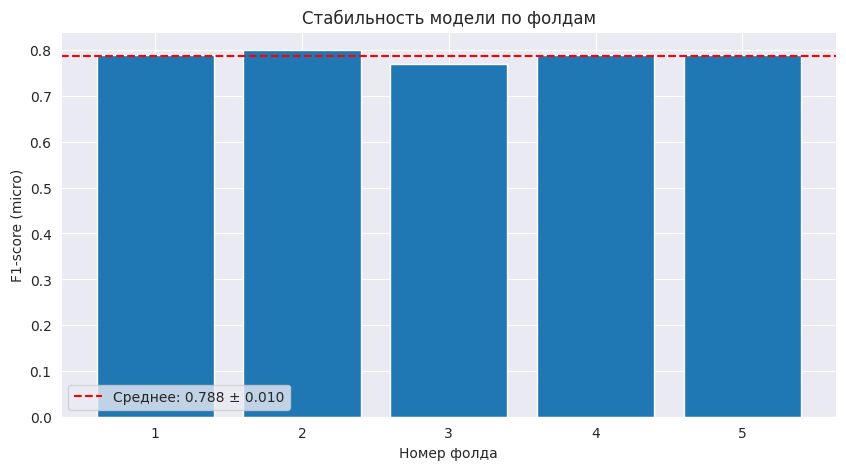

In [19]:
f1_scores = []
for _, report in fold_metrics:
    f1_match = re.search(r"micro avg.*?0\.\d+", report)
    if f1_match:
        f1 = float(f1_match.group().split()[-1])
        f1_scores.append(f1)

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(f1_scores)+1), f1_scores)
plt.axhline(np.mean(f1_scores), color='r', linestyle='--',
            label=f'Среднее: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}')
plt.xlabel("Номер фолда")
plt.ylabel("F1-score (micro)")
plt.title("Стабильность модели по фолдам")
plt.legend()
plt.show()

In [20]:
def report_to_df(report_str):
    """Универсальный парсер classification_report для мультиязычных меток"""
    # Чистим и стандартизируем отчет
    lines = []
    for line in report_str.split('\n'):
        line = re.sub(r'\s+', ' ', line.strip())  # Заменяем множественные пробелы
        if line and not line.startswith('---'):
            lines.append(line)

    # Разбираем вручную
    data = []
    for line in lines:
        # Пропускаем заголовки и средние
        if line.startswith('precision') or 'avg' in line:
            continue

        parts = line.split()
        if len(parts) >= 5:
            # Название класса может содержать пробелы - объединяем все кроме последних 4 элементов
            class_name = ' '.join(parts[:-4])
            metrics = parts[-4:]

            try:
                data.append({
                    'class': class_name,
                    'precision': float(metrics[0]),
                    'recall': float(metrics[1]),
                    'f1': float(metrics[2]),
                    'support': int(metrics[3])
                })
            except (ValueError, IndexError):
                continue

    return pd.DataFrame(data)

In [21]:
# После получения test_report
test_analyze_df = report_to_df(test_report)

print("\nТоп-6 лучших классов:")
print(test_analyze_df.sort_values('f1', ascending=False).head(6))

print("\nТоп-6 проблемных классов:")
print(test_analyze_df.sort_values('f1').head(6))


Топ-6 лучших классов:
              class  precision  recall    f1  support
31     Морская рыба       0.98    0.95  0.97       60
53      Овощи гриль       0.97    0.95  0.96       59
33         Сухарики       0.90    1.00  0.95       52
35   Гниющее дерево       0.91    0.98  0.95       54
40          Ежевика       0.91    0.96  0.94       55
104         Кремень       0.98    0.90  0.94       63

Топ-6 проблемных классов:
                class  precision  recall    f1  support
108  Черная смородина       0.02    1.00  0.03        1
93     Цукини/кабачок       0.10    1.00  0.19        6
36              Кокос       0.14    1.00  0.24        8
77    Сахар/ карамель       0.79    0.17  0.28      274
41              Флокс       0.17    1.00  0.29       10
9              Клюква       0.19    0.92  0.31       12


Функция для предсказания дескрипторов для строк с пустыми дескрипторами

In [22]:
def predict_for_empty(row, trainer, threshold=0.3):
    """Функция для предсказания дескрипторов чая"""
    try:
        # Проверяем, нужно ли делать предсказание (если дескрипторы отсутствуют или пусты)
        if pd.isna(row['descriptors']).any() or len(row['descriptors']) == 0 :
            preds = trainer.predict(row['description'])
            # Фильтруем предсказания по порогу вероятности
            return [desc[0] for desc in preds if desc[1] > threshold]
        # Возвращаем пустой список если предсказание не требуется
        return []
    except Exception as e:
        # Логируем ошибку, но продолжаем работу
        print(f"Ошибка предсказания для строки {row.name}: {str(e)}")
        return []

In [23]:
tea_df['bert_descriptors'] = tea_df.apply(lambda x: predict_for_empty(x, trainer), axis=1)

Вывод всего датафрейма с готовыми предсказаниями

In [24]:
tea_df

,id,title,description,comments,descriptors,feature,price,available_tea,tea_category,url,description_with_comments,bert_descriptors
0,0,"Цзяньши Хуа Сянь Даньцун ""Цветочный аромат из ...",\nЭтот Дань Цун принадлежи ароматическому проф...,[],"[Жасмин, Флокс, Орхидея, Жженый сахар, Лилия, ...","{'Партия:': 'июнь 2025', 'Провинция:': 'Гуанду...",1160.00,True,"[Улунский чай, Гуандунский улун (Дань цун)]",https://daochai.ru/vid-chaya/ulun/guandunskie-...,\nЭтот Дань Цун принадлежи ароматическому проф...,[]
1,1,"Цзюань Е Найбай ""Белое молоко"", 2025 HQ",\nНевероятно красивый чай-альбинос из уезда Ан...,[],[],"{'Партия:': 'июнь 2025', 'Провинция:': 'Чжэцзя...",2277.00,True,[Зеленый чай],https://daochai.ru/vid-chaya/zeljonyj-chaj/czy...,\nНевероятно красивый чай-альбинос из уезда Ан...,"[Овощной бульон, Лук (корень), Водоросли, Огур..."
2,2,"Нинхун Хунча, 2025","\nАромат сухого листа выраженно хлебный, с пло...",[],"[Хлебная корочка, Бисквит, Кедровый, Гвоздика,...","{'Партия:': 'июнь 2025', 'Провинция:': 'Цзянси...",362.00,True,[Красный чай],https://daochai.ru/vid-chaya/krasnyj-chaj/ninh...,"\nАромат сухого листа выраженно хлебный, с пло...",[]
3,3,"Габа чай ""Изумруд"", 2025","\nЦинсин улун, прошедший процедуру ферментации...",[Буду первым. Приятная габа по приятой цене. Н...,"[Вишня, Бисквит, Топленое молоко, Яблоко, Клюк...","{'Партия:': 'июнь 2025', 'Провинция:': 'Тайван...",580.00,True,"[Улунский чай, Тайваньский улун]",https://daochai.ru/vid-chaya/ulun/taiwan-ulun/...,"\nЦинсин улун, прошедший процедуру ферментации...",[]
4,4,"Габа чай ""Янтарь"", 2025",\nЭта габа ароматом сухого листа напоминает “И...,[],"[Вишня, Персик, Компот, Мята/ментол, Яблоко, П...","{'Партия:': 'июнь 2025', 'Провинция:': 'Тайван...",821.00,True,"[Улунский чай, Тайваньский улун]",https://daochai.ru/vid-chaya/ulun/taiwan-ulun/...,\nЭта габа ароматом сухого листа напоминает “И...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...
976,995,"Шен Сяо Иу ""Малый Иу"", пресс, 2019",\nМини блин 50гр моносортового шена из линейки...,"[Удивительно, что из четырех мини-блинчиков на...",[],{'Провинция:': 'Юньнань 云南'},9.00,False,"[Пуэр, Шен пуэр]",https://daochai.ru/vid-chaya/pu-erh/shen/shen-...,\nМини блин 50гр моносортового шена из линейки...,"[Сухая трава/солома, Манго, Карамелизированные..."
977,996,"Шен Сяо Сигуй ""Малый Сигуй"", пресс, 2019",\nСяо Сигуй - яркий представитель шенов с мощн...,"[Мягкий шэн, не боится кипятка. Вкус свежий, з...","[Персик, Компот, Водоросли, Овощной бульон, По...",{'Провинция:': 'Юньнань 云南'},9.00,False,"[Пуэр, Шен пуэр]",https://daochai.ru/vid-chaya/pu-erh/shen/shen-...,\nСяо Сигуй - яркий представитель шенов с мощн...,[]
978,997,"Хуан Цзинь Е Дань Цун ""Золотой лист"", 2020 осень",\nНеобычный во всех отношениях даньцун от внеш...,[Вместо ДаньЦуна в пакетике оказался аньсийски...,[],{'Провинция:': 'Гуандун 广东'},18.40,False,"[Улунский чай, Гуандунский улун (Дань цун)]",https://daochai.ru/vid-chaya/ulun/guandunskie-...,\nНеобычный во всех отношениях даньцун от внеш...,"[Ежевика, Сельдерей, Карамелизированные фрукты..."
979,998,"Моли Хуа Дань Цун ""Аромат цветов жасмина"", 202...","\nВ сухом листе маленькие жгутики, которые зам...",[вот интересно - почему так мало отзывов на эт...,[],{'Провинция:': 'Гуандун 广东'},32.00,False,"[Улунский чай, Гуандунский улун (Дань цун)]",https://daochai.ru/vid-chaya/ulun/guandunskie-...,"\nВ сухом листе маленькие жгутики, которые зам...","[Жасмин, Хризантема, Базилик, Полевые/луговые ..."


In [30]:
tea_df.to_excel("Tea_Classificator_Augment with LLM_Left_Cutting_predictred.xlsx", index=False)